<a href="https://colab.research.google.com/github/nv-hiep/GNOMES21/blob/main/SRC19_gfitflex_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here I used Carl's IDL code and translated it into Python.

I applied the Python code to the case of 3C286 which was checked by Claire. She also used Carl's IDL code to test. And I also applied the Python code to other cases of HT03 (3C333, 3C348, 3C433, 4C20.33 and P1055+20)

Please see the .ipynb files in /gfit/some_sources_HT03/

# 0. SOURCE SRC19

SOURCE: SRC19

SRC19: (RA1950 ,DEC1950)= (144.8847 +13.9917)

(ra, dec)_1950 = (09 39 31.8, 13 59 32)


*************************

Input: Equatorial B1950.0

RA or Longitude   DEC or Latitude   PA(East of North)

144.88258500      13.99229400       0.000000     

09h39m31.82040s   +13d59m32.2584s

Output: Galactic 
220.00968894      44.00672726       294.752475

http://www.robertmartinayers.org/tools/coordinates.html

Modern: 220.0097°  44.0068°

Old: 188.2054°  45.4162°    //    188.2205°  45.4045°

# 1. Libraries

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= '2.0'

if not tf.config.list_physical_devices('GPU'):
  print('No GPU was detected. LSTMs and CNNs can be very slow without a GPU.')
  if IS_COLAB:
    print('Go to Runtime > Change runtime and select a GPU hardware accelerator.')

# Common imports
import os
import shutil
import itertools
import glob
import numpy as np
import matplotlib.image as mpimg
import pandas as pd

import string
import random
import pickle
import itertools

from tqdm import tqdm
from time import time
from PIL import Image


# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rc('axes', labelsize=14)
# mpl.rc('xtick', labelsize=12)
# mpl.rc('ytick', labelsize=12)

In [2]:
from scipy.io import readsav
from astropy.io import fits

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
# !pip install latex
# ! apt install texlive texlive-latex-extra texlive-fonts-recommended dvipng

# 2. Connect to Google Drive

In [4]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

Sun Jul 18 17:01:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
gdrive	sample_data


In [6]:
# %cd /content/gdrive/My Drive/
%cd /content/gdrive/My Drive/Colab Notebooks/gfit/
!ls

/content/gdrive/My Drive/Colab Notebooks/gfit
data  old    some_sources_HT03			SRC19_gfitflex_python.ipynb
libs  plots  SRC19_gfitflex_pyhon_simple.ipynb


In [7]:
! pwd

/content/gdrive/My Drive/Colab Notebooks/gfit


## 3. Paths to Data Directories

In [8]:
PROJECT_PATH    = '/content/gdrive/My Drive/Colab Notebooks/gfit'
DATA_PATH       = os.path.join( PROJECT_PATH, 'data' )
PLOT_PATH       = os.path.join( PROJECT_PATH, 'plots' )

HT03_PATH       = os.path.join( DATA_PATH, 'HT03' )
HASLAM_PATH     = os.path.join( DATA_PATH, 'Haslam' )
SPONGE_DATA     = os.path.join( DATA_PATH, 'SPONGE21' )

GNOMES_PATH     = os.path.join( DATA_PATH, 'GNOMES21' )

HT03_HI_SPECTRA = os.path.join( HT03_PATH, 'MS_HI_spectra.npy' )
HT03_FIT_PARAMS = os.path.join( HT03_PATH, 'MS_gfit_params_dict.npy' )
TB_408_SAV      = os.path.join( HASLAM_PATH, 'tb_408.sav' )

HT03_PLOTS      = os.path.join( PLOT_PATH, 'HT03' )

In [9]:
import libs.gfitflex as fitlib

# 4. Background Temperature from 408MHz (Haslam et al.)

In [10]:
## Retreive a SINGLE value of 408 t_b from haslam et al. ##
 #
 # params float ell Galactic-longitude
 # params float bee Galactic-latitude
 #
 # return float Tbg_408 Background-Temperature at (l,b)
 #
 # version 08/2016 
 # author Nguyen Van Hiep ##
def get_tb_408(ell,bee,tb_408):
	iell= round(( modangle(ell)/360.)* 1080.)
	ibee= round( (( modangle( bee, 360., negpos=True)+90.)/180.)* 540)

	return tb_408[int(ibee), int(iell)]

## Convert angle to a specified range by finding the angle modulo the extent of the range. ##
 #
 # params 
 # params 
 #
 # return 
 #
 # version 08/2016 
 # author Nguyen Van Hiep ##
def modangle(angle, extent=360., negpos=False):
	offset = 0.
	if(negpos):
		offset = extent/2.

	return ((((angle-offset) % extent) + extent) % extent) - offset



## @galactic_coordinates.pro
## print, 'gl gb', gl, ' ', gb
## tsky=predict_sync(gl,gb, nu=1.4, /interp)+2.725 

inf408 = readsav(TB_408_SAV)
# tbg408 = get_tb_408(gl, gb, inf408.tb_408)
# tsky = 2.725 + txtDat.get_tb_408(ell, bee, inf408.tb_408)*(408./1420.405)**2.8 # Tbg from 408MHz

# 5. Read data

In [11]:
data = readsav( os.path.join(GNOMES_PATH, 'SRC19_a2770.sav'), python_dict=True)

In [12]:
data['src19']

rec.array([(b'SRC19', 9.658839, 13.992294, array([ 164.73051,  164.56949,  164.40845, ..., -164.56949, -164.73051,
       -164.89154], dtype=float32), 69.76162, array([-4.35543197, -3.49763262, -3.57728367, ..., -0.97562059,
       -1.6386037 , -1.59687491]), array([0.94912891, 0.89370015, 0.94315673, ..., 0.94135083, 0.96927345,
       1.00187909]))],
          dtype=[(('hdrsrcname', 'HDRSRCNAME'), 'O'), (('ra', 'RA'), '>f4'), (('dec', 'DEC'), '>f4'), (('vlsr', 'VLSR'), 'O'), (('tsrc', 'TSRC'), '>f4'), (('t_exptd', 'T_EXPTD'), 'O'), (('exp_m_tau', 'EXP_M_TAU'), 'O')])

In [13]:
df = pd.DataFrame.from_records(data['src19'])

In [14]:
df

,HDRSRCNAME,RA,DEC,VLSR,TSRC,T_EXPTD,EXP_M_TAU
0,b'SRC19',9.658839,13.992294,"[164.73051, 164.56949, 164.40845, 164.24742, 1...",69.76162,"[-4.355431971831763, -3.497632616634313, -3.57...","[0.9491289070346856, 0.8937001508934731, 0.943..."


In [15]:
df.columns

Index(['HDRSRCNAME', 'RA', 'DEC', 'VLSR', 'TSRC', 'T_EXPTD', 'EXP_M_TAU'], dtype='object')

In [16]:
df.iloc[0]['HDRSRCNAME']

b'SRC19'

In [17]:
df.iloc[0]['RA']

9.658839

In [18]:
df.iloc[0]['DEC']

13.992294

In [19]:
df.iloc[0]['VLSR']

array([ 164.73051,  164.56949,  164.40845, ..., -164.56949, -164.73051,
       -164.89154], dtype=float32)

In [20]:
df.iloc[0]['TSRC']

69.76162

In [21]:
df.iloc[0]['T_EXPTD']

array([-4.35543197, -3.49763262, -3.57728367, ..., -0.97562059,
       -1.6386037 , -1.59687491])

In [22]:
df.iloc[0]['EXP_M_TAU']

array([0.94912891, 0.89370015, 0.94315673, ..., 0.94135083, 0.96927345,
       1.00187909])

In [23]:
# Input: Equatorial B1950.0

# RA or Longitude   DEC or Latitude   PA(East of North)
# 144.88258500      13.99229400       0.000000     
# 09h39m31.82040s   +13d59m32.2584s

# Output: Galactic 
# 220.00968894      44.00672726       294.752475

# http://www.robertmartinayers.org/tools/coordinates.html
# Modern: 220.0097°  44.0068°
# Old: 188.2054°  45.4162°    //    188.2205°  45.4045°

In [24]:
# Background temperature
gl = 220.00968894
gb = 44.00672726
tbg408 = get_tb_408(gl, gb, inf408.tb_408)
tsky   = 2.725 + tbg408*(408./1420.405)**2.8 # Tbg from 408MHz
print('Tbg_408 (MHz): ', tbg408)
print('T_sky: ', tsky)

Tbg_408 (MHz):  25.0
T_sky:  3.4853863754372583


# 7. Fitting with Python

In [25]:
# source name
src = 'SRC19'

## 7.1 Plot spectra for the fit using Python

In [26]:
# Prepare for the fit
abs_vlsr = df.iloc[0]['VLSR']
em_vlsr  = df.iloc[0]['VLSR']
emt      = df.iloc[0]['EXP_M_TAU']
Tb       = 0.5*df.iloc[0]['T_EXPTD']

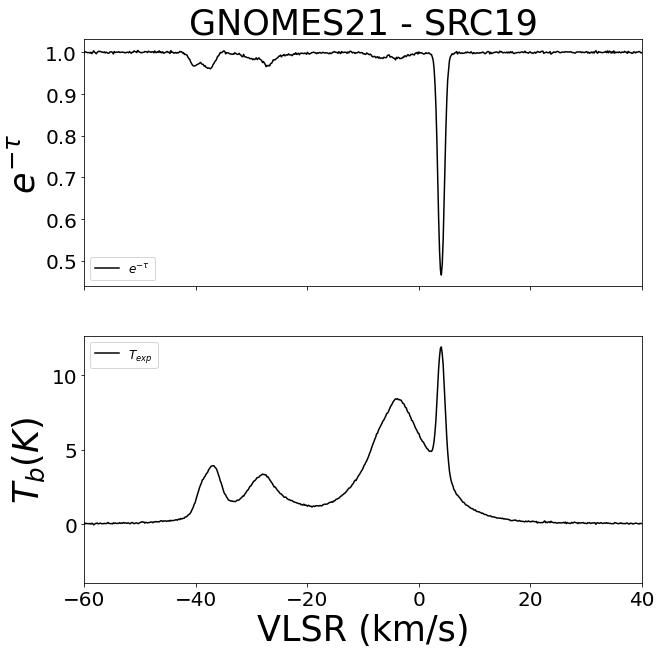

In [27]:
## Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10), sharex=True)

## Absorption
ax1.plot(abs_vlsr, emt, 'k-', label=r'$e^{-\tau}$')
# ax1.fill_between(v_tau, emt-sigemt, emt+sigemt, color='gray', label=r'')

ax1.set_title('GNOMES21 - ' + src, fontsize = 35)
ax1.set_ylabel(r'$e^{-\tau}$', fontsize = 35)
# ax1.set_xlabel('VLSR (km/s)', fontsize = 35)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.set_xlim(-60., 40.)
ax1.legend(loc='lower left', fontsize=12)

## Emission
ax2.plot(em_vlsr, Tb, 'k-', label=r'$T_{exp}$')
# ax2.fill_between(v_tb, tb-sigtb, tb+sigtb, color='gray', label=r'')


ax2.set_ylabel('$T_{b} (K)$', fontsize = 35)
ax2.set_xlabel('VLSR (km/s)', fontsize = 35)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.set_xlim(-60., 40.)
ax2.legend(loc='upper left', fontsize=12)

# plt.savefig(src + '.png', bbox_inches='tight', pad_inches=0.09, format='png', dpi=150)

plt.show()
plt.close(fig)

## 7.2 Gaussian fit

In [28]:
print('Fitting... ' + src)

Fitting... SRC19


In [29]:
# Initial Gaussian guesses for the absorption spectrum
zro0   = 0.0

# hgt0   = [0.04, 0.05, 0.03, 0.01, 0.7]
# cen0   = [-40., -38., -28., -6., 2.]
# wid0   = [2., 3., 4., 5., 2.]

# cen0   = [-41., -36., -28., -30., -10., -5., 5]
# hgt0   = [0.02, 0.02, 0.01, 0.01, 0.005, 0.005, 0.5]
# wid0   = [2.,   1.,   2.,   1.,   0.5,     0.5,   2.]


cen0   = [-41., -36., -30., -5., 5.]
hgt0   = [0.02, 0.02, 0.005, 0.005, 0.5]
wid0   = [2.,   1.,   1,     0.5,   2.]

look   = 0

nrg    = len(hgt0)
zro0yn = 0
hgt0yn = [1]*nrg
cen0yn = [1]*nrg
wid0yn = [1]*nrg
corder = 'no'

## WNM
tspin0 = [0.]*nrg
order0 = list(range(nrg))

zro0yn   = 0
tau0yn   = [1]*nrg
cenc0yn  = [1]*nrg
wid0yn   = [1]*nrg
tspin0yn = [0]*nrg

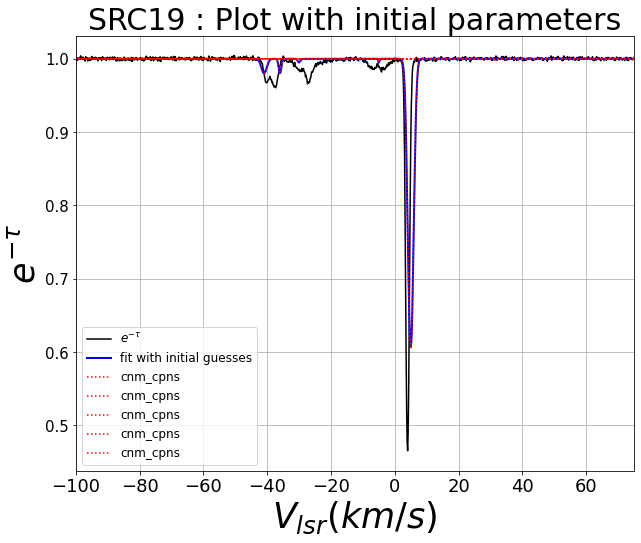

In [30]:
# Plot with initial parameters
if True:
  plt.figure(figsize=(10,8))
  
  ## Fit these guesses
  tau0  = fitlib.gcurv(abs_vlsr, zro0, hgt0, cen0, wid0)
  tfit0 = np.exp(-tau0)

  # Abs data
  plt.plot(abs_vlsr, emt, 'k-', label=r'$e^{-\tau}$')

  # ABS line - From Guesses
  plt.plot(abs_vlsr, tfit0, 'b-', linewidth=2, label='fit with initial guesses')

  for ccen, chgt, cwid in zip(cen0, hgt0, wid0):
    plt.plot( abs_vlsr, np.exp(-fitlib.gcurv(abs_vlsr, 0., [chgt], [ccen], [cwid]) ), 'r:', label='cnm_cpns')


  plt.title(src + ' : Plot with initial parameters', fontsize=30)
  plt.ylabel(r'$e^{-\tau}$', fontsize=35)
  plt.xlabel('$V_{lsr} (km/s)$', fontsize=35)
  
  # plt.ylim(0.0, 2.0)
  plt.xlim(-100., 75.)

  plt.grid(True)
  plt.tick_params(axis='x', labelsize=18)
  plt.tick_params(axis='y', labelsize=15)
  plt.legend(loc='lower left', fontsize=12)
  plt.show()

### 7.2.1 Fit the opacity profile $e^{-\tau}$

In [31]:
tfita, sigma, resida,\
zro1, hgt1, cen1, wid1,\
sigzro1, sighgt1, sigcen1, sigwid1,\
cov, problem, nparams = fitlib.emt_fit(look, abs_vlsr, emt, [0, len(emt)-1], zro0, hgt0, cen0, wid0, zro0yn, hgt0yn, cen0yn, wid0yn)

print('Absorption line: problem...', problem)

print('1. sigma ', sigma)
print('2. Zro ', zro1)
print('3. tau ', np.round(hgt1, 4))
print('\t\t', np.round(sighgt1, 3))
print('4. cen ', np.round(cen1, 3))
print('\t\t', np.round(sigcen1, 3))
print('5. wid ', np.round(wid1, 3))
print('\t\t', np.round(sigwid1, 3))

Number of bins:  2048
Absorption line: problem... 0
1. sigma  0.02473066371310472
2. Zro  0.0
3. tau  [0.0321 0.0406 0.0248 0.0137 0.7562]
		 [0.011 0.01  0.006 0.005 0.024]
4. cen  [-40.202 -37.628 -27.562  -5.027   4.004]
		 [0.549 0.473 0.674 1.335 0.015]
5. wid  [1.952 2.252 5.763 6.913 1.221]
		 [1.151 1.049 1.584 3.152 0.032]


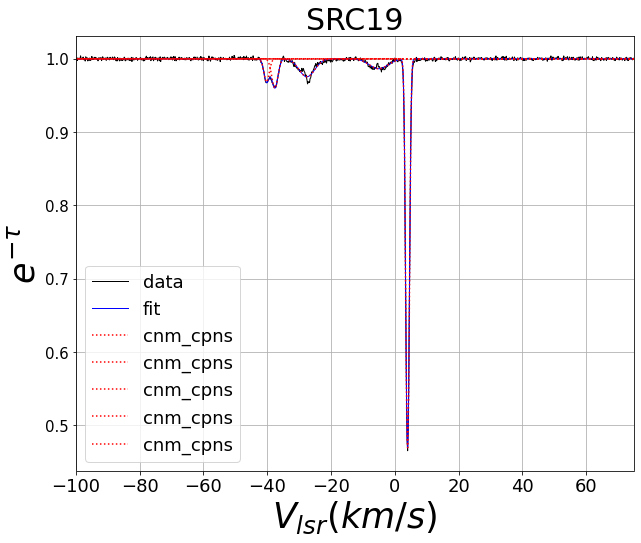

In [32]:
## Absoprtion line
sum_of_gaussians = fitlib.gcurv(abs_vlsr, zro1, hgt1, cen1, wid1)
emt_fit          = np.exp(-sum_of_gaussians)

plt.figure(figsize=(10,8))
plt.plot(abs_vlsr, emt, 'k-', linewidth=1, label='data')
plt.plot(abs_vlsr, emt_fit, 'b-', linewidth=1, label='fit')

for ccen, chgt, cwid in zip(cen1, hgt1, wid1):
  plt.plot( abs_vlsr, np.exp(-fitlib.gcurv(abs_vlsr, 0., [chgt], [ccen], [cwid]) ), 'r:', label='cnm_cpns')


plt.title(src, fontsize=30)
plt.ylabel(r'$e^{-\tau}$', fontsize=35)
plt.xlabel('$V_{lsr} (km/s)$', fontsize=35)
# plt.ylim(0.9, 1.01)
plt.xlim(-100., 75.)

plt.grid(True)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=15)

# plt.text(0.0, 3.2, r'$f = [0.32\pm0.06]\cdot log_{10}(N^*_{HI}/10^{20}) + [0.81\pm0.05]$, Lee et al.', color='blue', fontsize=20)
plt.legend(loc='lower left', fontsize=18)
plt.show()

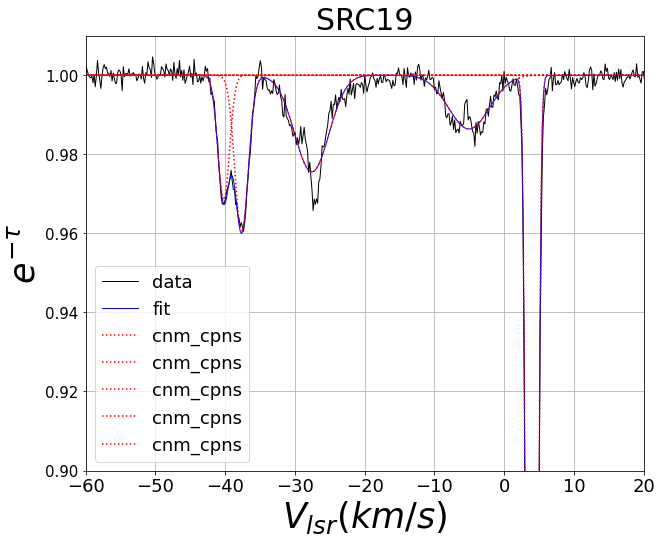

In [33]:
## Absoprtion line
sum_of_gaussians = fitlib.gcurv(abs_vlsr, zro1, hgt1, cen1, wid1)
emt_fit          = np.exp(-sum_of_gaussians)

plt.figure(figsize=(10,8))
plt.plot(abs_vlsr, emt, 'k-', linewidth=1, label='data')
plt.plot(abs_vlsr, emt_fit, 'b-', linewidth=1, label='fit')

for ccen, chgt, cwid in zip(cen1, hgt1, wid1):
  plt.plot( abs_vlsr, np.exp(-fitlib.gcurv(abs_vlsr, 0., [chgt], [ccen], [cwid]) ), 'r:', label='cnm_cpns')


plt.title(src, fontsize=30)
plt.ylabel(r'$e^{-\tau}$', fontsize=35)
plt.xlabel('$V_{lsr} (km/s)$', fontsize=35)
plt.ylim(0.9, 1.01)
plt.xlim(-60., 20.)

plt.grid(True)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=15)

# plt.text(0.0, 3.2, r'$f = [0.32\pm0.06]\cdot log_{10}(N^*_{HI}/10^{20}) + [0.81\pm0.05]$, Lee et al.', color='blue', fontsize=20)
plt.legend(loc='lower left', fontsize=18)
plt.show()

### 7.2.2 Fit the $T_\mathrm{exp}$ profile

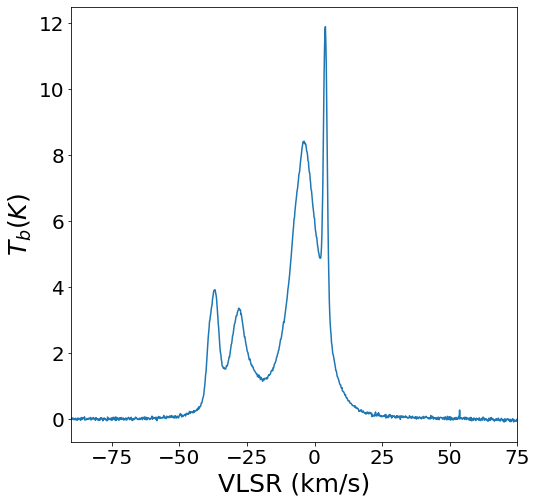

In [34]:
vmin, vmax = fitlib.get_vrange_id(em_vlsr, -90., 75.)
tb_vlsr    = np.array(em_vlsr[vmin:vmax+1], dtype='float64')
Tb         = np.array(Tb[vmin:vmax+1], dtype='float64')

plt.figure(figsize=(8,8))

plt.plot(tb_vlsr, Tb)

plt.ylabel('$T_{b} (K)$', fontsize = 25)
plt.xlabel('VLSR (km/s)', fontsize = 25)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.xlim(-90., 75.)
plt.show()

In [35]:
# Initial guesses
zrownm1   = 0.
hgtwnm1   = [2., 3.]
cenwnm1   = [-30., -1.]
widwnm1   = [15., 15.]
look      = 0
nrgwnm    = len(hgtwnm1)
zrownm1yn = 1
hgtwnm1yn = [1]*nrgwnm
cenwnm1yn = [1]*nrgwnm
widwnm1yn = [1]*nrgwnm
fwnm1     = [0.5]*nrgwnm
fwnm1yn   = [0]*nrgwnm # Don't change here

order1    = [0] if nrg==1 else list(range(nrg))
tspin1    = [30.]*nrg
tspin1yn  = [1]*nrg

zrocnm1   = 0.
hgtcnm1   = hgt1
cencnm1   = cen1
widcnm1   = wid1
zrocnm1yn = 0
hgtcnm1yn = [0]*nrg
cencnm1yn = [0]*nrg
widcnm1yn = [0]*nrg

look      = -1
xindxrange= [0, len(tb_vlsr)-1]

## ---Parameters within tbgfitflex_exp.pro, sets number of loops (nloopmax)
## ---and the fractional change in each parameter per loop iteration
nloopmax     = 100
halfasseduse = 0.2


## @galactic_coordinates.pro
## print, 'gl gb', gl, ' ', gb
## tsky=predict_sync(gl,gb, nu=1.4, /interp)+2.725 
tdata = Tb + tsky
cont  = tsky

In [39]:
simple = False
if simple:
  tfita, sigmaw, reside,\
  zrocnm2, hgtcnm2, cencnm2, widcnm2, tspin2,\
  sigzrocnm2, sighgtcnm2, sigcencnm2, sigwidcnm2, sigtspin2,\
  zrownm2, hgtwnm2, cenwnm2, widwnm2, fwnm2,\
  sigzrownm2, sighgtwnm2, sigcenwnm2, sigwidwnm2, sigfwnm2,\
  cov, problem, nloop,\
  tb_cont, tb_wnm_tot, tb_cnm_tot,\
  exp_tau_sum, nloopmax, halfasseduse = fitlib.texp_fit(look, tb_vlsr, tdata, xindxrange,
                                                        zrocnm1, hgtcnm1, cencnm1, widcnm1, tspin1, order1,
                                                        zrocnm1yn, hgtcnm1yn, cencnm1yn, widcnm1yn, tspin1yn,
                                                        cont, hgtwnm1, cenwnm1, widwnm1, fwnm1,
                                                        1, hgtwnm1yn, cenwnm1yn, widwnm1yn, fwnm1yn, nloopmax=nloopmax, halfasseduse=0.2)
  tb_tot_fit = tfita-tsky
  tdata      = tdata-tsky
else:
  print( 'Not Simple!!')
  nrgcnm = nrg
  if ( (nrgcnm == 0) or (nrgcnm == 1) ):
    orders = [[0]]
  else:
    ## Orders of (peaks) components
    orders = list(itertools.permutations(range(nrgcnm)))
    orders = [list(x) for x in orders]
  ## Endif for orders

  n_loops = np.math.factorial(nrgcnm)

  # NEWLY ADDED
  if nrgcnm > 4:
    n_loops = np.math.factorial(4) # = 24
    orders  = random.sample(orders, 24)


  f_pom      = np.zeros( (3**nrgwnm, nrgwnm), dtype='float64')             #fltarr(nrgwnm,3^nrgwnm)
  sigmas     = np.zeros( 3**nrgwnm*n_loops, dtype='float64')               #fltarr(3^nrgwnm*factorial(nrgcnm))
  Tspins     = np.zeros( (3**nrgwnm*n_loops, nrgcnm), dtype='float64')     ## fltarr(nrgcnm, 3^nrgwnm*factorial(nrgcnm))
  Tspins_err = np.zeros( (3**nrgwnm*n_loops, nrgcnm), dtype='float64')     ## fltarr(nrgcnm, 3^nrgwnm*factorial(nrgcnm))

  Fs         = np.zeros( (3**nrgwnm*n_loops, nrgwnm) ) ## fltarr(ncnm, 3^nwnm*factorial(ncnm))
  sigFs      = np.zeros( (3**nrgwnm*n_loops, nrgwnm) ) ## fltarr(ncnm, 3^nwnm*factorial(ncnm))

  # sigmatemp  = np.zeros( n_loops, dtype='float64')                         ## fltarr(factorial(nrgcnm))
  orders_all = np.zeros( (3**nrgwnm*n_loops, nrgcnm), dtype='float64')     ## fltarr(nrgcnm,3^nrgwnm*factorial(nrgcnm))
  fwnm_all   = np.zeros( (3**nrgwnm*n_loops, nrgwnm) )

  for k in range(nrgwnm):
    f_pom[:,k] = np.mod( np.arange(3**nrgwnm)/3**k, 3 )

  # f_pom = f_pom*0.5
  f_pom = np.floor(f_pom)*0.5

  # if nrgwnm = 2 ->
  # [[0.  0. ]
  #  [0.5 0. ]
  #  [1.  0. ]
  #  [0.  0.5]
  #  [0.5 0.5]
  #  [1.  0.5]
  #  [0.  1. ]
  #  [0.5 1. ]
  #  [1.  1. ]]

  for j in range(3**nrgwnm):
    fwnm1 = f_pom[j,:]
    print( '\n ************* \n Starting orders loop: ', j)
    print( str(100.*round( float(j)/float(3**nrgwnm),2 ) ) + '%')

    for oval in range(n_loops):
      order1 = orders[oval]

      look = -1

      tfita, sigmaw, reside,\
      zrocnm2, hgtcnm2, cencnm2, widcnm2, tspin2, \
      sigzrocnm2, sighgtcnm2, sigcencnm2, sigwidcnm2, sigtspin2, \
      zrownm2, hgtwnm2, cenwnm2, widwnm2, fwnm2, \
      sigzrownm2, sighgtwnm2, sigcenwnm2, sigwidwnm2, sigfwnm2, \
      cov, problem, nloop, \
      tb_cont, tb_wnm_tot, tb_cnm_tot, \
      exp_tau_sum, nloopmax, halfasseduse = fitlib.texp_fit(look, tb_vlsr, tdata, xindxrange, \
            zrocnm1, hgtcnm1, cencnm1, widcnm1, tspin1, order1, \
            zrocnm1yn, hgtcnm1yn, cencnm1yn, widcnm1yn, tspin1yn, \
            cont, hgtwnm1, cenwnm1, widwnm1, fwnm1, \
            1, hgtwnm1yn, cenwnm1yn, widwnm1yn, fwnm1yn, nloopmax=nloopmax, halfasseduse=0.2)

      if ( np.any(tspin2<tsky) or np.any(hgtwnm2<1.) or np.any(widwnm2<2.) or np.any(widwnm2>80.) ):
        continue
      
      # print( '>>>>:')
      # print( 'fwnm: ', f_pom[j, :])
      # print( 'order1:', order1)
      # print( 'Tspin: ', tspin2)
      # print( '   - sigTsin:', sigtspin2)
      # print(' Sigma: ', sigmaw)

      sigmas[j*n_loops+oval]        = sigmaw
      Tspins[j*n_loops+oval, :]     = tspin2
      Tspins_err[j*n_loops+oval, :] = sigtspin2

      orders_all[j*n_loops+oval, :] = order1
      fwnm_all[j*n_loops+oval, :]   = fwnm1

      Fs[j*n_loops+oval, :]         = fwnm2
      sigFs[j*n_loops+oval, :]      = sigfwnm2
		## Endfor oval
	## Endfor j

  print('End looping!')

  tspin_final      = np.zeros( nrgcnm, dtype='float64')
  tspin_err_final  = np.zeros( nrgcnm, dtype='float64')
  F                = (n_loops)*(3**nrgwnm)
  w                = (1./sigmas)**2
  
  for j in range(nrgcnm):
    tspin_val = np.sum(w*Tspins[:,j])/np.sum(w)

    tspin_err = ( np.sum( w*((Tspins[:,j]-tspin_val)**2+Tspins_err[:,j]**2) )/np.sum(w) )*(F/(F-1.))
    tspin_err = np.sqrt(tspin_err)

    tspin_final[j]     = tspin_val
    tspin_err_final[j] = tspin_err
	## Endfor

  print( '---------------------------')
  print( 'Final:')
  print( 'Tspin: ', tspin_final, '\n +/-', tspin_err_final)

  ## Fwnms
  fs_final    = np.zeros( nrgwnm )
  sigfs_final = np.zeros( nrgwnm )
  for j in range(nrgwnm):
    fs_val = np.sum(w*Fs[:,j])/np.sum(w)
    sigfs  = ( np.sum( w*((Fs[:,j]-fs_val)**2 + sigFs[:,j]**2) )/np.sum(w) )*(F/(F-1.))
    sigfs  = np.sqrt(sigfs/ float(n_loops) )

    fs_final[j]    = fs_val
    sigfs_final[j] = sigfs
  # End - for

  print( 'F(k): ', fs_final, '\n +/-', sigfs_final)

  m = np.argmin(sigmas)
  print( 'where sigmas is min:', m, sigmas[m])

  fwnm1   = f_pom[ int( np.floor( float(m)/n_loops ) ), :]
  order1  = orders[ int(np.mod(float(m), n_loops ) )]
  fwnm1yn = [0]*nrgwnm # do not change

  print( 'fwnm: ', fwnm1)
  print( 'order1: ', order1)



  ## Do the last fit
  look = -1

  tfita, sigmaw, reside,\
  zrocnm2, hgtcnm2, cencnm2, widcnm2, tspin2, \
  sigzrocnm2, sighgtcnm2, sigcencnm2, sigwidcnm2, sigtspin2, \
  zrownm2, hgtwnm2, cenwnm2, widwnm2, fwnm2, \
  sigzrownm2, sighgtwnm2, sigcenwnm2, sigwidwnm2, sigfwnm2, \
  cov, problem, nloop, \
  tb_cont, tb_wnm_tot, tb_cnm_tot, \
  exp_tau_sum, nloopmax, halfasseduse = fitlib.texp_fit(look, tb_vlsr, tdata, xindxrange, \
        zrocnm1, hgtcnm1, cencnm1, widcnm1, tspin1, order1, \
        zrocnm1yn, hgtcnm1yn, cencnm1yn, widcnm1yn, tspin1yn, \
        cont, hgtwnm1, cenwnm1, widwnm1, fwnm1, \
        1, hgtwnm1yn, cenwnm1yn, widwnm1yn, fwnm1yn, nloopmax=nloopmax, halfasseduse=0.2)

  tb_tot_fit = tfita-tsky
  tdata      = tdata-tsky
## End else

Not Simple!!

 ************* 
 Starting orders loop:  0
0.0%

 ************* 
 Starting orders loop:  1
11.0%

 ************* 
 Starting orders loop:  2
22.0%

 ************* 
 Starting orders loop:  3
33.0%

 ************* 
 Starting orders loop:  4
44.0%

 ************* 
 Starting orders loop:  5
56.00000000000001%

 ************* 
 Starting orders loop:  6
67.0%

 ************* 
 Starting orders loop:  7
78.0%

 ************* 
 Starting orders loop:  8
89.0%
End looping!
---------------------------
Final:
Tspin:  [ 18.79250945  80.83978033  49.09668175 167.21256003  21.34637576] 
 +/- [2.30064805 1.76465118 2.80848784 6.7673035  1.54163502]
F(k):  [0.5004212  0.50036056] 
 +/- [0.08352686 0.08351692]
where sigmas is min: 199 0.17984286782328773
fwnm:  [1. 1.]
order1:  [3, 1, 2, 0, 4]


In [46]:
print( 'Expected Emission profile: problem...', problem)
print( 'Nloop:', nloop)
print( 'xindxrange:', xindxrange)

print( 'Length of VLSR indices (xindxrange): ', len(xindxrange))
print( 'Length of Tb data: ', len(tdata))
print( 'Length of Tb_tot_fit: ', len(tb_tot_fit))

Expected Emission profile: problem... 0
Nloop: 53
xindxrange: [0, 1025]
Length of VLSR indices (xindxrange):  2
Length of Tb data:  1026
Length of Tb_tot_fit:  1026


In [47]:
print('')
print('CNM:')
print( '1. sigma: ', np.round(sigmaw, 3))
print( '2. Zro: ', np.round(zro1, 3))
print( '3. tau: ', np.round(hgt1, 4))
print( '\t sigtau: ', np.round(sighgt1, 4))
print( '4. cen: ', np.round(cen1, 3))
print( '\t sigcen: ', np.round(sigcen1, 3))
print( '5. wid: ', np.round(wid1, 3))
print( '\t sigwid:', np.round(sigwid1, 3))
print( '6. Tspin: ', np.round(tspin2, 3))
print( '\t sig_Tspin: ', np.round(sigtspin2, 3))

print()
print('WNM:')
print( '7. hgt-WNM: ', np.round(hgtwnm2, 3))
print( '\t sighgt: ', np.round(sighgtwnm2, 3))
print( '8. V0-WNM: ', np.round(cenwnm2, 3))
print( '\t sigcen: ', np.round(sigcenwnm2, 3))
print( '9. Width-WNM: ', np.round(widwnm2, 3))
print( '\t sigwid: ', np.round(sigwidwnm2, 3))
print( '10. fwnm1-WNM: ', np.round(fwnm2, 3))
print( '\t sig_fwnm: ', np.round(sigfwnm2, 3))
if not simple:
  print( '11. fwnm final: ', np.round(fs_final, 3))
  print( '\t sig_fwnm final: ', np.round(sigfs_final, 3))


CNM:
1. sigma:  0.18
2. Zro:  0.0
3. tau:  [0.0321 0.0406 0.0248 0.0137 0.7562]
	 sigtau:  [0.011  0.0099 0.006  0.0054 0.024 ]
4. cen:  [-40.202 -37.628 -27.562  -5.027   4.004]
	 sigcen:  [0.549 0.473 0.674 1.335 0.015]
5. wid:  [1.952 2.252 5.763 6.913 1.221]
	 sigwid: [1.151 1.049 1.584 3.152 0.032]
6. Tspin:  [ 18.312  80.198  48.127 164.706  19.464]
	 sig_Tspin:  [2.281 1.694 2.697 6.437 0.151]

WNM:
7. hgt-WNM:  [1.973 6.113]
	 sighgt:  [0.044 0.064]
8. V0-WNM:  [-29.578  -2.519]
	 sigcen:  [0.153 0.052]
9. Width-WNM:  [19.194 15.554]
	 sigwid:  [0.415 0.103]
10. fwnm1-WNM:  [1. 1.]
	 sig_fwnm:  [0. 0.]
11. fwnm final:  [0.5 0.5]
	 sig_fwnm final:  [0.084 0.084]


In [48]:
print('tb_cont: ', tb_cont[:5])

tb_cont:  [3.50922674 3.50922674 3.50922674 3.50922674 3.50922674]


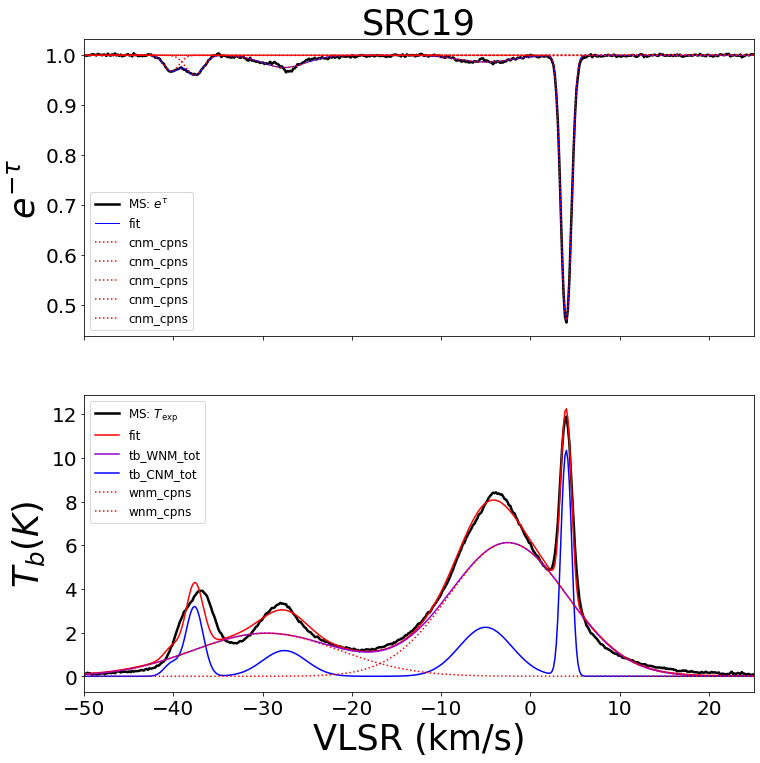

In [49]:
# Plot spectra
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,12))

ax1.plot(abs_vlsr, emt, 'k-', linewidth=2.5, label=r'MS: $e^{\tau}$')
ax1.plot(abs_vlsr, emt_fit, 'b-', linewidth=1, label='fit')

for ccen, chgt, cwid in zip(cen1, hgt1, wid1):
  ax1.plot( abs_vlsr, np.exp(-fitlib.gcurv(abs_vlsr, 0., [chgt], [ccen], [cwid]) ), 'r:', label='cnm_cpns')

ax1.set_title(src, fontsize = 35)
ax1.set_ylabel(r'$e^{-{\tau}}$', fontsize = 35)
# ax1.set_xlabel('VLSR (km/s)', fontsize = 35)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax2.set_xlim(-50., 25.)
ax1.legend(loc='lower left', fontsize=12)





## EM spec
ax2.plot(tb_vlsr, tdata, 'k-', lw=2.5, label=r'MS: $T_\mathrm{exp}$')

ax2.plot(tb_vlsr, tb_tot_fit, 'r-', label='fit')
ax2.plot(tb_vlsr, tb_wnm_tot, color='darkviolet', ls='-', label='tb_WNM_tot')
ax2.plot(tb_vlsr, tb_cnm_tot, 'b-', label='tb_CNM_tot')

for wcen, whgt, wwid in zip(cenwnm2, hgtwnm2, widwnm2):
  ax2.plot( tb_vlsr, fitlib.gcurv(tb_vlsr, 0., [whgt], [wcen], [wwid]), 'r:', label='wnm_cpns')

# ax2.set_title(sc, fontsize = 35)
ax2.set_ylabel('$T_{b} (K)$', fontsize = 35)
ax2.set_xlabel('VLSR (km/s)', fontsize = 35)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

ax2.set_xlim(-50., 25.)

plt.legend(loc='upper left', fontsize=12)

# Save the plot
plt.savefig( os.path.join(HT03_PLOTS, src + '_python.png'), bbox_inches='tight', pad_inches=0.09, format='png', dpi=150)

plt.show()
plt.close(fig)
print()

In [50]:
# Summary
print('Source: ', src)

print('')
print('CNM:')
print( '1. sigma: ', np.round(sigmaw, 3))
print( '2. Zro: ', np.round(zro1, 3))
print( '3. tau: ', np.round(hgt1, 4))
print( '\t sigtau: ', np.round(sighgt1, 4))
print( '4. cen: ', np.round(cen1, 3))
print( '\t sigcen: ', np.round(sigcen1, 3))
print( '5. wid: ', np.round(wid1, 3))
print( '\t sigwid:', np.round(sigwid1, 3))
print( '6. Tspin: ', np.round(tspin2, 3))
print( '\t sig_Tspin: ', np.round(sigtspin2, 3))

print()
print('WNM:')
print( '7. hgt-WNM: ', np.round(hgtwnm2, 3))
print( '\t sighgt: ', np.round(sighgtwnm2, 3))
print( '8. V0-WNM: ', np.round(cenwnm2, 3))
print( '\t sigcen: ', np.round(sigcenwnm2, 3))
print( '9. Width-WNM: ', np.round(widwnm2, 3))
print( '\t sigwid: ', np.round(sigwidwnm2, 3))
# print( '10. fwnm1-WNM: ', np.round(fwnm2, 3))
# print( '\t sig_fwnm: ', np.round(sigfwnm2, 3))
if not simple:
  print( '10. fwnm final: ', np.round(fs_final, 3))
  print( '\t sig_fwnm final: ', np.round(sigfs_final, 3))

print()
print()

## Calculating column densities ##
NH_cnm       = 1.064467 * 0.0183 * 1. * hgt1 * wid1 * tspin2
pom          = sighgt1**2*(0.0194797*wid1*tspin2)**2 + sigwid1**2*(0.0194797*hgt1*tspin2)**2 + sigtspin2*(0.0194797*hgt1*wid1)**2
delta_NH_cnm = np.sqrt(pom)
print( 'NH_cnm: ', np.round(NH_cnm,3), '+/-', np.round(delta_NH_cnm,3) )

NH_wnm       = 1.064467 * 0.0183 * 1. * hgtwnm2 * widwnm2
pomw         = NH_wnm**2*( (sighgtwnm2/hgtwnm2)**2 + (sigwidwnm2/widwnm2)**2 )
delta_NH_wnm = np.sqrt(pomw)
print( 'NH_wnm: ', np.round(NH_wnm,4), ' +/-', np.round(delta_NH_wnm, 4) )

## solving for Tkmax
Tkmax    = 21.855*wid1**2
sigTkmax = (sigwid1/wid1)*2*Tkmax

Tkmaxw    = 21.855*(widwnm2)**2
sigTkmaxw = (sigwidwnm2/widwnm2)*2*Tkmaxw

print( 'Sigma for the fit: ', round(sigmaw,4))
print()

print( '>Tkmax (WNM):', np.round(Tkmaxw, 3))
print( '>>> sigTkmax (WNM): ', np.round(sigTkmaxw, 3))
print()
print( '>Tkmax (CNM):', np.round(Tkmax, 3))
print( '>>> sigTkmax (CNM): ', np.round(sigTkmax, 3))
print()
print( '>Tspin[K]: ', np.round(tspin2, 3))
print( '>>sigTspin[K]: ', np.round(sigtspin2, 3))

Source:  SRC19

CNM:
1. sigma:  0.18
2. Zro:  0.0
3. tau:  [0.0321 0.0406 0.0248 0.0137 0.7562]
	 sigtau:  [0.011  0.0099 0.006  0.0054 0.024 ]
4. cen:  [-40.202 -37.628 -27.562  -5.027   4.004]
	 sigcen:  [0.549 0.473 0.674 1.335 0.015]
5. wid:  [1.952 2.252 5.763 6.913 1.221]
	 sigwid: [1.151 1.049 1.584 3.152 0.032]
6. Tspin:  [ 18.312  80.198  48.127 164.706  19.464]
	 sig_Tspin:  [2.281 1.694 2.697 6.437 0.151]

WNM:
7. hgt-WNM:  [1.973 6.113]
	 sighgt:  [0.044 0.064]
8. V0-WNM:  [-29.578  -2.519]
	 sigcen:  [0.153 0.052]
9. Width-WNM:  [19.194 15.554]
	 sigwid:  [0.415 0.103]
10. fwnm final:  [0.5 0.5]
	 sig_fwnm final:  [0.084 0.084]


NH_cnm:  [0.022 0.143 0.134 0.304 0.35 ] +/- [0.015 0.075 0.049 0.183 0.016]
NH_wnm:  [0.7376 1.8521]  +/- [0.0228 0.0229]
Sigma for the fit:  0.1798

>Tkmax (WNM): [8051.541 5287.441]
>>> sigTkmax (WNM):  [348.286  70.323]

>Tkmax (CNM): [  83.278  110.882  725.741 1044.561   32.593]
>>> sigTkmax (CNM):  [ 98.188 103.247 398.879 952.554   1.703]
